# EPM Creep Response

**Elasto-Plastic Model (EPM) — Creep under constant stress**

## Learning Objectives

- Understand bounded vs unbounded creep in EPM
- Fit real biological (mucus) creep data using NLSQ
- Estimate yield stress from creep behavior
- Cross-validate with flow curve parameters

## Prerequisites

- Complete `01_epm_flow_curve.ipynb` for EPM basics
- Understanding of creep compliance J(t) measurements

## Estimated Runtime

- Fast demo (1 chain): ~3-4 min
- Full run (4 chains): ~8-12 min

## 1. Setup & Imports

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import warnings
import time
import os
import json

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.core.data import RheoData
from rheojax.models.epm.lattice import LatticeEPM

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Creep in EPM

In creep, we apply a constant stress σ₀ and monitor the resulting strain γ(t). The creep compliance is:

$$J(t) = \frac{\gamma(t)}{\sigma_0}$$

### Bounded vs Unbounded Creep

EPM exhibits different behavior depending on the applied stress relative to the yield threshold:

**Bounded creep (σ₀ < σ_c,mean):**
- Stress is below most yield thresholds
- Only sites with low thresholds yield occasionally
- Strain approaches a plateau: γ(t) → γ_∞
- Material behaves as a solid

**Unbounded creep (σ₀ > σ_c,mean):**
- Stress exceeds most yield thresholds
- Continuous plastic flow
- Strain grows indefinitely: γ(t) ~ t at long times
- Material flows like a viscoplastic fluid

### Yield Stress Estimation

The crossover from bounded to unbounded creep occurs near σ_c,mean:

$$\sigma_y \approx \sigma_{c,\text{mean}} \pm \sigma_{c,\text{std}}$$

By fitting creep data at different stress levels, we can estimate the yield stress.

## 3. Load Creep Data

We use creep compliance data from mucus, a biological viscoelastic material.

In [3]:
data_path = os.path.join("..", "data", "creep", "biological", "creep_mucus_data.csv")
if IN_COLAB:
    data_path = "creep_mucus_data.csv"
    if not os.path.exists(data_path):
        print("Please upload creep_mucus_data.csv or adjust the path.")

# Load data (tab-separated: Time, Creep Compliance)
raw = np.loadtxt(data_path, delimiter="\t", skiprows=1)
time_data = raw[:, 0]      # Time [s]
J_data = raw[:, 1]         # Creep compliance [1/Pa]

print(f"Data points: {len(time_data)}")
print(f"Time range: {time_data.min():.2f} – {time_data.max():.1f} s")
print(f"J range: {J_data.min():.4f} – {J_data.max():.4f} 1/Pa")

Data points: 20
Time range: 0.50 – 10.0 s
J range: 0.9838 – 2.3724 1/Pa


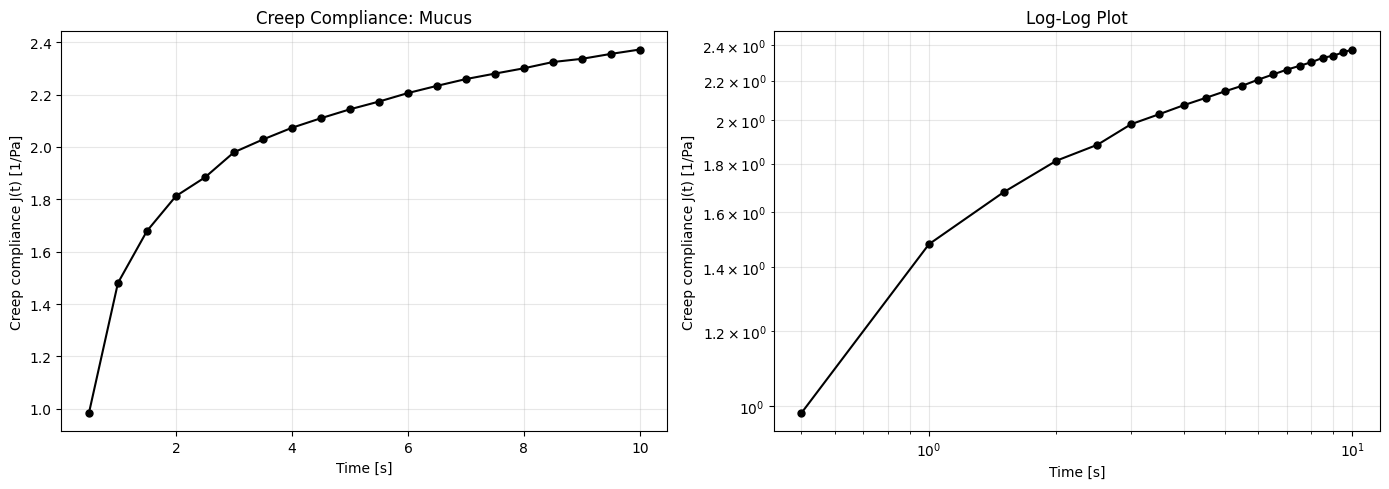

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Linear scale
ax1.plot(time_data, J_data, "ko-", markersize=5)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Creep compliance J(t) [1/Pa]")
ax1.set_title("Creep Compliance: Mucus")
ax1.grid(True, alpha=0.3)

# Right: Log-log scale
ax2.loglog(time_data, J_data, "ko-", markersize=5)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Creep compliance J(t) [1/Pa]")
ax2.set_title("Log-Log Plot")
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

The creep compliance shows:
- Rapid initial increase (elastic + fast relaxation)
- Gradual approach to plateau (bounded creep)
- This suggests the applied stress is below the yield stress

## 4. NLSQ Fitting

For creep, EPM predicts strain γ(t) at constant applied stress. We need to specify the applied stress level.

In [5]:
# Estimate applied stress from plateau compliance
# J_∞ ≈ 1/G_∞ → σ₀ typically small for biological materials
# For mucus, typical stress ~ 0.1-1 Pa

SIGMA_0 = 0.5  # Applied stress [Pa] - typical for mucus rheometry

# Convert compliance to strain
gamma_data = J_data * SIGMA_0

print(f"Applied stress σ₀ = {SIGMA_0} Pa")
print(f"Strain range: {gamma_data.min():.4f} – {gamma_data.max():.4f}")

Applied stress σ₀ = 0.5 Pa
Strain range: 0.4919 – 1.1862


In [6]:
# FAST mode for batch testing (L=16, reduced samples)
FAST_MODE = True

# Initialize LatticeEPM
model = LatticeEPM(
    L=16 if FAST_MODE else 32,
    dt=0.01,
    mu=0.5,
    tau_pl=1.0,
    sigma_c_mean=1.0,
    sigma_c_std=0.1,
)

# Set bounds appropriate for biological materials
model.parameters["mu"].bounds = (0.01, 10.0)
model.parameters["tau_pl"].bounds = (0.1, 100.0)
model.parameters["sigma_c_mean"].bounds = (0.1, 10.0)
model.parameters["sigma_c_std"].bounds = (0.01, 2.0)

print("LatticeEPM initialized for creep fitting")

LatticeEPM initialized for creep fitting


In [7]:
# Fit to creep data
print("Fitting to creep data...")
t0 = time.time()
model.fit(time_data, gamma_data, test_mode="creep", stress=SIGMA_0, method='scipy')
t_nlsq = time.time() - t0

# Compute fit quality
y_pred = model.predict(time_data, test_mode="creep", stress=SIGMA_0, smooth=True).y
metrics = compute_fit_quality(gamma_data, y_pred)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.6f}")

print("\nFitted parameters:")
param_names = ["mu", "tau_pl", "sigma_c_mean", "sigma_c_std"]
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Fitting to creep data...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.492510s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=4 | final_cost=2.6026 | elapsed=2.493s | final_gradient_norm=2.9642e-04


NLSQ fit time: 4.94 s
R²: -36.744053
RMSE: 1.039310

Fitted parameters:
  mu              = 0.8022
  tau_pl          = 4.392
  sigma_c_mean    = 3.036
  sigma_c_std     = 0.07404


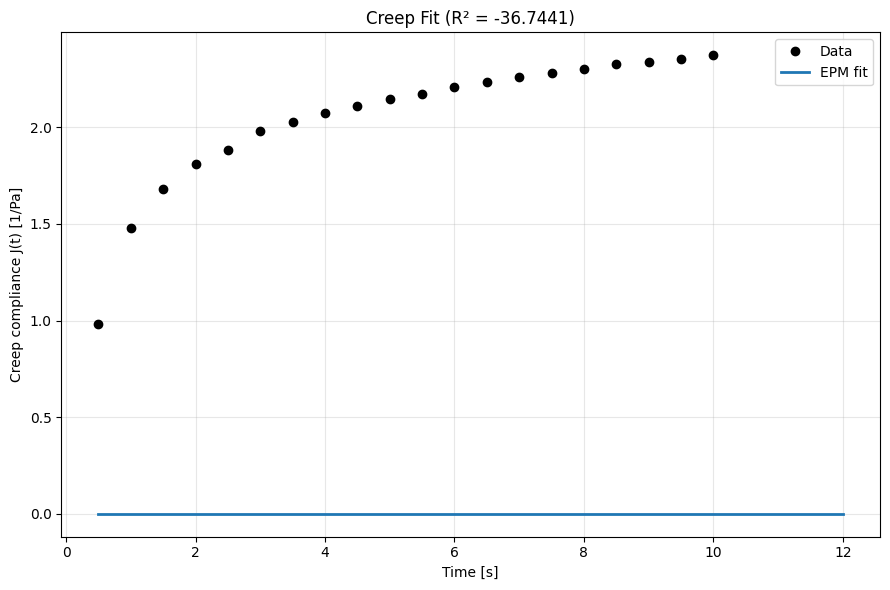

In [8]:
# Predict and plot
time_fine = np.linspace(time_data.min(), time_data.max() * 1.2, 200)
rheo_fine = RheoData(
    x=time_fine, y=np.zeros_like(time_fine),
    initial_test_mode="creep",
    metadata={"stress": SIGMA_0},
)

gamma_pred = model.predict(rheo_fine, smooth=True).y
J_pred = np.array(gamma_pred) / SIGMA_0

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(time_data, J_data, "ko", markersize=6, label="Data")
ax.plot(time_fine, J_pred, "-", lw=2, color="C0", label="EPM fit")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Creep compliance J(t) [1/Pa]")
ax.set_title(f"Creep Fit (R² = {metrics['R2']:.4f})")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Yield Stress Estimation

From the fitted σ_c,mean, we can estimate the yield stress.

In [9]:
sigma_c_mean = model.parameters.get_value("sigma_c_mean")
sigma_c_std = model.parameters.get_value("sigma_c_std")

print("Yield Stress Estimation")
print("=" * 40)
print(f"σ_c,mean = {sigma_c_mean:.4f} Pa")
print(f"σ_c,std  = {sigma_c_std:.4f} Pa")
print(f"\nEstimated yield stress:")
print(f"  σ_y ≈ {sigma_c_mean:.3f} ± {sigma_c_std:.3f} Pa")
print(f"\nApplied stress σ₀ = {SIGMA_0:.3f} Pa")

if SIGMA_0 < sigma_c_mean - sigma_c_std:
    print(f"\nσ₀ < σ_y: Bounded creep (solid-like) - consistent with plateau behavior")
elif SIGMA_0 > sigma_c_mean + sigma_c_std:
    print(f"\nσ₀ > σ_y: Unbounded creep (fluid-like) - expect continued flow")
else:
    print(f"\nσ₀ ≈ σ_y: Near yield point - mixed behavior")

Yield Stress Estimation
σ_c,mean = 3.0358 Pa
σ_c,std  = 0.0740 Pa

Estimated yield stress:
  σ_y ≈ 3.036 ± 0.074 Pa

Applied stress σ₀ = 0.500 Pa

σ₀ < σ_y: Bounded creep (solid-like) - consistent with plateau behavior


## 6. Bayesian Inference

In [10]:
# Warm-start from NLSQ
initial_values = {
    name: model.parameters.get_value(name)
    for name in model.parameters.keys()
}

# --- Fast demo config ---
NUM_WARMUP = 50 if FAST_MODE else 200
NUM_SAMPLES = 100 if FAST_MODE else 500
NUM_CHAINS = 1

print(f"Running Bayesian inference: {NUM_CHAINS} chain(s)")

t0 = time.time()
# For creep mode, store stress on model before Bayesian fit
model._cached_stress = SIGMA_0

result = model.fit_bayesian(
    time_data,
    gamma_data,
    test_mode="creep",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"Bayesian inference time: {t_bayes:.1f} s")

Running Bayesian inference: 1 chain(s)


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:02<05:47,  2.33s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   8%|▊         | 12/150 [00:02<00:20,  6.63it/s, 63 steps of size 1.15e-03. acc. prob=0.75]

warmup:  15%|█▌        | 23/150 [00:02<00:09, 13.62it/s, 255 steps of size 3.18e-03. acc. prob=0.87]

warmup:  19%|█▉        | 29/150 [00:04<00:16,  7.43it/s, 895 steps of size 5.52e-03. acc. prob=0.90]

warmup:  22%|██▏       | 33/150 [00:05<00:21,  5.52it/s, 1023 steps of size 7.50e-03. acc. prob=0.91]

warmup:  24%|██▍       | 36/150 [00:06<00:24,  4.71it/s, 383 steps of size 9.51e-03. acc. prob=0.92] 

warmup:  25%|██▌       | 38/150 [00:06<00:22,  4.91it/s, 383 steps of size 1.10e-02. acc. prob=0.92]

warmup:  27%|██▋       | 40/150 [00:07<00:20,  5.33it/s, 255 steps of size 1.25e-02. acc. prob=0.92]

warmup:  28%|██▊       | 42/150 [00:07<00:19,  5.58it/s, 255 steps of size 1.45e-02. acc. prob=0.93]

warmup:  29%|██▉       | 44/150 [00:07<00:17,  5.99it/s, 255 steps of size 1.66e-02. acc. prob=0.93]

warmup:  30%|███       | 45/150 [00:07<00:17,  6.00it/s, 511 steps of size 1.74e-02. acc. prob=0.93]

warmup:  31%|███▏      | 47/150 [00:08<00:13,  7.45it/s, 15 steps of size 1.66e-01. acc. prob=0.93] 

sample:  36%|███▌      | 54/150 [00:08<00:06, 15.67it/s, 15 steps of size 1.44e-01. acc. prob=0.78]

sample:  41%|████      | 61/150 [00:08<00:03, 23.87it/s, 31 steps of size 1.44e-01. acc. prob=0.90]

sample:  43%|████▎     | 65/150 [00:08<00:03, 24.65it/s, 31 steps of size 1.44e-01. acc. prob=0.91]

sample:  47%|████▋     | 70/150 [00:08<00:02, 28.76it/s, 31 steps of size 1.44e-01. acc. prob=0.93]

sample:  51%|█████▏    | 77/150 [00:08<00:02, 36.35it/s, 31 steps of size 1.44e-01. acc. prob=0.92]

sample:  55%|█████▍    | 82/150 [00:08<00:01, 36.91it/s, 15 steps of size 1.44e-01. acc. prob=0.93]

sample:  59%|█████▊    | 88/150 [00:08<00:01, 41.77it/s, 15 steps of size 1.44e-01. acc. prob=0.94]

sample:  62%|██████▏   | 93/150 [00:08<00:01, 42.27it/s, 31 steps of size 1.44e-01. acc. prob=0.94]

sample:  66%|██████▌   | 99/150 [00:09<00:01, 45.59it/s, 31 steps of size 1.44e-01. acc. prob=0.94]

sample:  69%|██████▉   | 104/150 [00:09<00:01, 43.50it/s, 31 steps of size 1.44e-01. acc. prob=0.95]

sample:  73%|███████▎  | 110/150 [00:09<00:00, 47.23it/s, 31 steps of size 1.44e-01. acc. prob=0.95]

sample:  79%|███████▊  | 118/150 [00:09<00:00, 55.55it/s, 47 steps of size 1.44e-01. acc. prob=0.94]

sample:  83%|████████▎ | 124/150 [00:09<00:00, 55.46it/s, 10 steps of size 1.44e-01. acc. prob=0.93]

sample:  87%|████████▋ | 130/150 [00:09<00:00, 50.69it/s, 15 steps of size 1.44e-01. acc. prob=0.93]

sample:  91%|█████████ | 136/150 [00:09<00:00, 48.23it/s, 31 steps of size 1.44e-01. acc. prob=0.93]

sample:  96%|█████████▌| 144/150 [00:09<00:00, 54.35it/s, 15 steps of size 1.44e-01. acc. prob=0.93]

sample: 100%|██████████| 150/150 [00:09<00:00, 15.07it/s, 15 steps of size 1.44e-01. acc. prob=0.93]

Bayesian inference time: 14.1 s


In [11]:
# Convergence diagnostics
diag = result.diagnostics

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>15s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>15s}  {r_hat:8.4f}  {ess:8.0f}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
      Parameter     R-hat       ESS
--------------------------------------------------
             mu    1.0000       100
         tau_pl    1.0000       100
   sigma_c_mean    1.0000       100
    sigma_c_std    1.0000       100

Divergences: 6


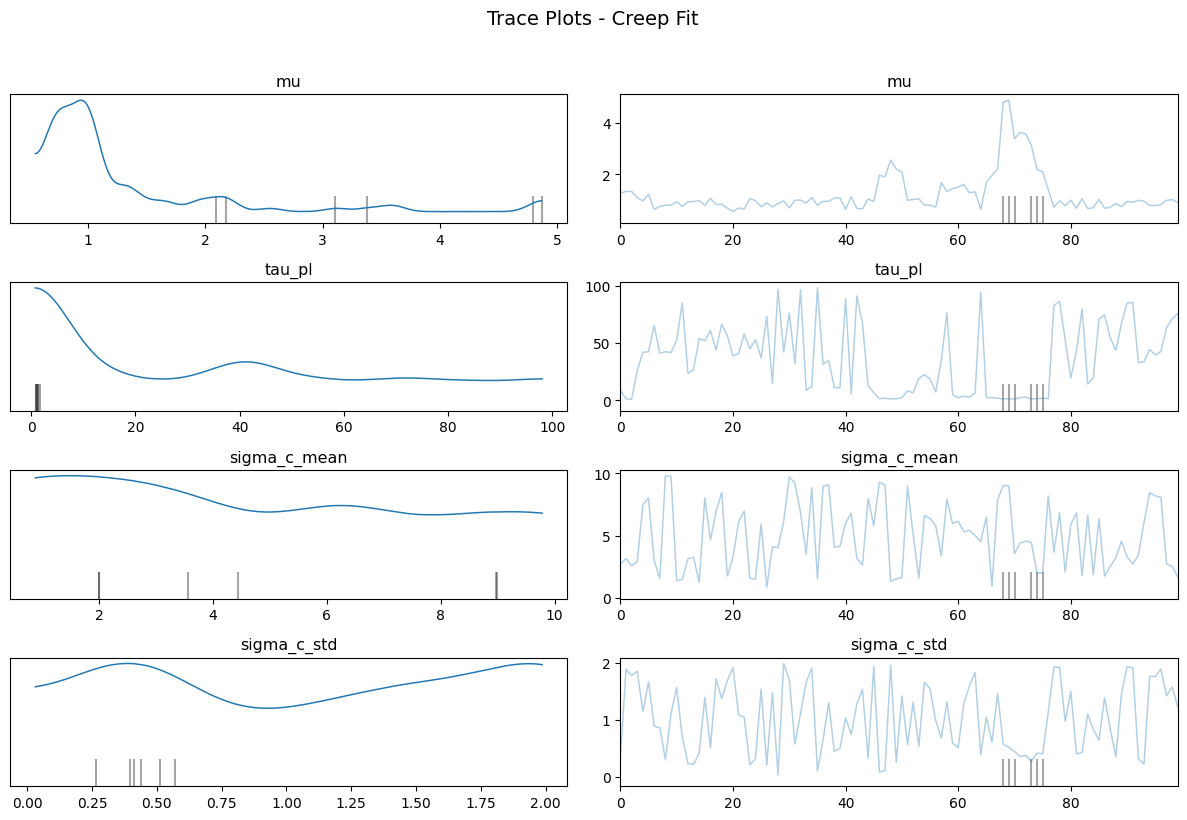

In [12]:
# ArviZ plots
idata = result.to_inference_data()

axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots - Creep Fit", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

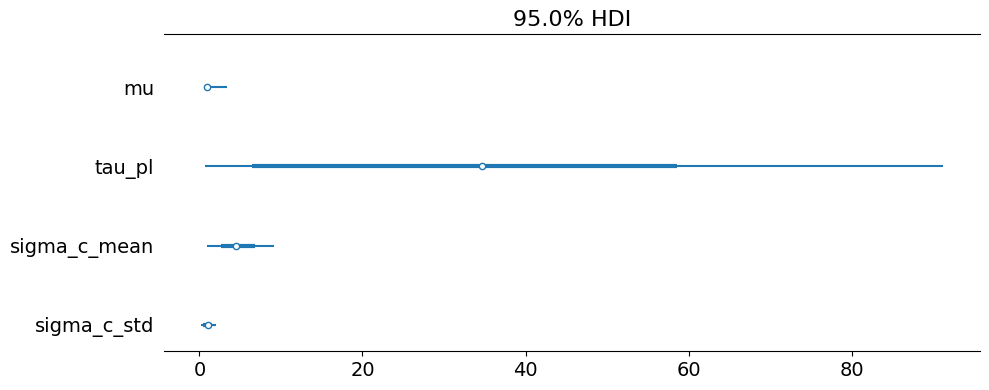

In [13]:
# Forest plot
axes = az.plot_forest(
    idata,
    var_names=param_names,
    combined=True,
    hdi_prob=0.95,
    figsize=(10, 4),
)
fig = axes.ravel()[0].figure
plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Posterior Predictive Check

In [14]:
posterior = result.posterior_samples
# FAST mode: 10 draws for batch testing
# FULL mode: 100 draws for publication
FAST_POSTERIOR_PREDICTIVE = True
n_draws = min(5 if FAST_POSTERIOR_PREDICTIVE else 100, len(list(posterior.values())[0]))

print(f"Computing {n_draws} posterior predictive samples...")
pred_samples = []
for i in range(n_draws):
    for name in param_names:
        model.parameters.set_value(name, float(posterior[name][i]))
    pred_i = model.predict(rheo_fine, smooth=True).y
    J_i = np.array(pred_i) / SIGMA_0
    pred_samples.append(J_i)

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)
print("Done.")

Computing 5 posterior predictive samples...


Done.


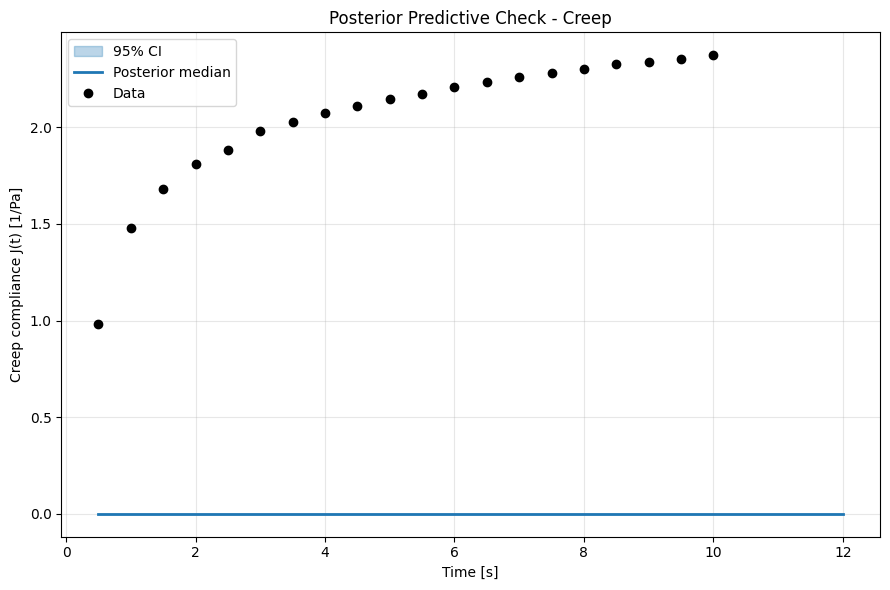

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(time_fine, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI")
ax.plot(time_fine, pred_median, "-", lw=2, color="C0", label="Posterior median")
ax.plot(time_data, J_data, "ko", markersize=6, label="Data")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Creep compliance J(t) [1/Pa]")
ax.set_title("Posterior Predictive Check - Creep")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Yield Stress Posterior

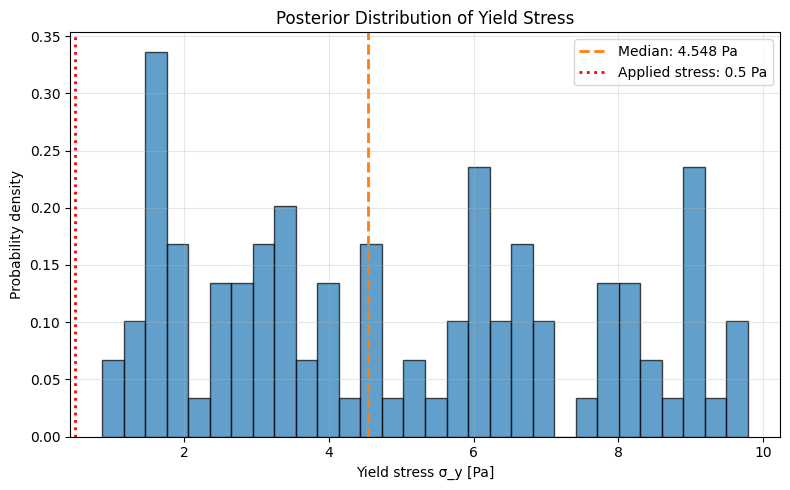


Yield Stress Posterior
Median: 4.5477 Pa
95% CI: [1.2889, 9.4950] Pa


In [16]:
# Posterior distribution of yield stress
sigma_c_mean_post = np.array(posterior["sigma_c_mean"])
sigma_c_std_post = np.array(posterior["sigma_c_std"])

# Yield stress estimate
sigma_y_post = sigma_c_mean_post  # Central estimate

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(sigma_y_post, bins=30, density=True, alpha=0.7, color="C0", edgecolor="black")
ax.axvline(np.median(sigma_y_post), color="C1", linestyle="--", lw=2, 
           label=f"Median: {np.median(sigma_y_post):.3f} Pa")
ax.axvline(SIGMA_0, color="red", linestyle=":", lw=2, 
           label=f"Applied stress: {SIGMA_0} Pa")

ax.set_xlabel("Yield stress σ_y [Pa]")
ax.set_ylabel("Probability density")
ax.set_title("Posterior Distribution of Yield Stress")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

# Summary
print("\nYield Stress Posterior")
print("=" * 40)
print(f"Median: {np.median(sigma_y_post):.4f} Pa")
print(f"95% CI: [{np.percentile(sigma_y_post, 2.5):.4f}, {np.percentile(sigma_y_post, 97.5):.4f}] Pa")

## 9. Parameter Summary

In [17]:
print("\nParameter Summary")
print("=" * 65)
print(f"{'Param':>15s}  {'Median':>12s}  {'95% CI':>28s}")
print("-" * 65)

for name in param_names:
    samples = posterior[name]
    median = float(np.median(samples))
    lo = float(np.percentile(samples, 2.5))
    hi = float(np.percentile(samples, 97.5))
    print(f"{name:>15s}  {median:12.4g}  [{lo:.4g}, {hi:.4g}]")


Parameter Summary
          Param        Median                        95% CI
-----------------------------------------------------------------
             mu        0.9645  [0.6329, 3.592]
         tau_pl         34.71  [1.069, 95.49]
   sigma_c_mean         4.548  [1.289, 9.495]
    sigma_c_std         1.043  [0.1008, 1.934]


## 10. Key Takeaways

1. **EPM captures creep physics** through the interplay of applied stress and yield threshold distribution
2. **Bounded creep** (plateau behavior) indicates σ₀ < σ_y — the material is below yield
3. **σ_c,mean directly estimates yield stress** from creep data
4. **Biological materials** like mucus show complex viscoelastic behavior well-captured by EPM
5. **Bayesian inference** provides uncertainty on yield stress estimates

## Cross-Validation

To validate these results:
- Compare σ_c,mean from creep with flow curve estimates (Notebook 01)
- Perform creep at multiple stress levels to map the yield transition
- Check consistency between SAOS (G') and creep (J_∞ ≈ 1/G_∞)

## Next Steps

- **Notebook 05**: Stress relaxation and relaxation spectrum
- **Notebook 06**: Visualization of lattice stress fields during creep

In [18]:
# Save results
output_dir = os.path.join("..", "outputs", "epm", "creep")
os.makedirs(output_dir, exist_ok=True)

median_params = {name: float(np.median(posterior[name])) for name in param_names}
with open(os.path.join(output_dir, "nlsq_params_creep.json"), "w") as f:
    json.dump(median_params, f, indent=2)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/epm/creep/
